# Deep Learning with Tensorflow on Amazon SageMaker and S3



## Imports

In [1]:
import sagemaker

print(sagemaker.__version__)
sess = sagemaker.Session()
# role = sagemaker.get_execution_role()
import os
from tensorflow import keras
import tensorflow as tf
import numpy as np
from sagemaker.inputs import FileSystemInput

2.31.1


In [2]:
tf.__version__

'2.4.1'

# Updated Local Training Run

In [7]:
from sagemaker.tensorflow import TensorFlow
import time

job_name = "pc_tf_local_test"
job_name = f'{job_name}-{time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())}'

def efs_path(filename):
    return "./efs" + "/" + filename 

# old_training_file = "labels_full_train_v6.csv"
# old_validation_file = "labels_val.csv"
# new_training_file = "new_train_labels_v5_10_percent.csv"
new_training_file = "new_train_labels_v9_verysmall.csv"
# new_training_file = "new_train_labels_v7_one_quarter.csv"
# new_validation_file = "new_val_labels_v3.csv"
# new_validation_file = "new_val_labels_v5_10000.csv"
# new_validation_file = "new_val_labels_v6_2000.csv"
new_validation_file = "new_val_labels_v9_verysmall.csv"




tf_estimator = TensorFlow(entry_point='train_no_s3.py', 
                          role="arn:aws:iam::963659202518:role/service-role/AmazonSageMaker-ExecutionRole-20210306T191865",
                          #                           role=get_execution_role(),
                          instance_count=1, 
                          instance_type='local', # ml.m5.large, ml.p3.16xlarge, ml.p3.2xlarge, ml.g4dn.xlarge, ml.p3.8xlarge, p3.2xlarge, ml.t2.micro
                          framework_version='2.4', 
                          base_job_name=job_name,
                          output_path='s3://canopy-production-ml-output',
                          py_version='py37',
                          script_mode=True,
                          hyperparameters={'training_file':new_training_file, 
                                           'validation_file': new_validation_file,
#                                            'bucket':"margaux-bucket-us-east-1",
                                           'epochs': 200, 'augment': False, 'batch-size': 64,
                                           'learning-rate': 0.0005, 'numclasses': 5,
                                           'wandb_key': "abfa0dec9fc06fbfa6392496f40a22a8d47e58cf",
                                           's3_chkpt_dir':"ckpt",
                                           'bands': "2 3 4 8 11 12 18",
                                          'starting_checkpoint':None, 
                                           'freeze_bn_layer':False,
                                           'model':"resnet50",
                                           'callback': "lrfinder",
                                           'clr_initial':.00001,
                                           'clr_max':.0005, 
                                           'clr_step':2500, 
                                           'lr_reduce_min': .00001
                                           
                                          }
                         )

Training

In [13]:
import time
tf_estimator.fit("file:////home/ec2-user/SageMaker/cb_feature_detection/model-development/efs")

Creating t7j5srpob1-algo-1-cob1y ... 
Creating t7j5srpob1-algo-1-cob1y ... done
Attaching to t7j5srpob1-algo-1-cob1y
t7j5srpob1-algo-1-cob1y | 2021-04-16 01:32:57.037048: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
t7j5srpob1-algo-1-cob1y | 2021-04-16 01:32:57.038102: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
t7j5srpob1-algo-1-cob1y | 2021-04-16 01:32:57.069878: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
t7j5srpob1-algo-1-cob1y | 2021-04-16 01:32:58,904 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
t7j5srpob1-algo-1-cob1y | 2021-04-16 01:32:58,911 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
t7j5srpob1-algo-1-cob1y | 2021-04-16 01:32:59,136 sage

KeyboardInterrupt: 

Training

# EC2 Instance Training

# FSX Input Obj

In [1]:
# # old_dataset_directory = '/h4zifbmv/chips/cloudfree-merge-polygons/split'
# new_dataset_directory = '/h4zifbmv/chips/cloudfree-merge-polygons/dataset_v2'


# fsx_data_obj = FileSystemInput(file_system_id='fs-03cd4325554338c21',
#                                     file_system_type='FSxLustre',
#                                     directory_path=new_dataset_directory,
#                                     file_system_access_mode='ro')

# EFS Input Obj

In [3]:
# old_dataset_directory = '/h4zifbmv/chips/cloudfree-merge-polygons/split'
new_dataset_directory = "/"


efs_data_obj = FileSystemInput(file_system_id='fs-f1777e44',
                                    file_system_type='EFS',
                                    directory_path=new_dataset_directory,
                                    file_system_access_mode='ro')

In [6]:
#TODO : LR update - min .0001 vs .00001, Data Aug - Enable "flip_left_right" 



from sagemaker.tensorflow import TensorFlow
from sagemaker.debugger import Rule, rule_configs
from sagemaker import get_execution_role
import time

job_name = 'pc-tf-custom-container'


# old_training_file = "labels_full_train_v6.csv"
# old_validation_file = "labels_val.csv"
# new_training_file = "new_train_labels_v5_10_percent.csv"
new_training_file = "new_train_labels_v9_verysmall.csv"
# new_training_file = "new_train_labels_v7_one_quarter.csv"
# new_validation_file = "new_val_labels_v3.csv"
# new_validation_file = "new_val_labels_v5_10000.csv"
# new_validation_file = "new_val_labels_v6_2000.csv"
new_validation_file = "new_val_labels_v9_verysmall.csv"
# old_band_combo = [2,3,4,8,12]
# band_rgbnir = [2,3,4,8,18]
# bands_all = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18]


tf_estimator = TensorFlow(entry_point='train_no_s3.py', 
                          role="arn:aws:iam::963659202518:role/service-role/AmazonSageMaker-ExecutionRole-20210306T191865",
                          #                           role=get_execution_role(),
                          instance_count=1, 
                          instance_type='ml.g4dn.4xlarge', # ml.m5.large, ml.p3.16xlarge, ml.p3.2xlarge, ml.g4dn.xlarge, ml.p3.8xlarge, p3.2xlarge, ml.t2.micro
                          framework_version='2.4', 
                          base_job_name=job_name,
                          output_path='s3://canopy-production-ml-output',
                          py_version='py37',
                          checkpoint_s3_uri=f's3://canopy-production-ml-output/ckpt/{job_name}-{time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())}',
                          script_mode=True,
                          use_spot_instances=True,        # Use spot instance
                          max_run=432000,                    # Max training time
                          max_wait=450000,                  # Max training time + spot waiting time
                            subnets=["subnet-815befde"],
                              security_group_ids=["sg-0df3ac3b4c291c080"],
                          hyperparameters={'training_file':new_training_file, 
                                           'validation_file': new_validation_file,
#                                            'bucket':"margaux-bucket-us-east-1",
                                           'epochs': 200, 'augment': False, 'batch-size': 64,
                                           'learning-rate': 0.0005, 'numclasses': 5,
                                           'wandb_key': "abfa0dec9fc06fbfa6392496f40a22a8d47e58cf",
                                           's3_chkpt_dir':"ckpt",
                                           'bands': "2 3 4 8 11 12 18",
                                          'starting_checkpoint':None, 
                                           'freeze_bn_layer':False,
                                           'model':"resnet50",
                                           'callback': "lrfinder",
                                           'clr_initial':.00001,
                                           'clr_max':.0005, 
                                           'clr_step':2500, 
                                           'lr_reduce_min': .00001
                                          }
                         )

In [7]:
tf_estimator.fit(efs_data_obj)

2021-04-14 19:07:07 Starting - Starting the training job...
2021-04-14 19:07:31 Starting - Launching requested ML instancesProfilerReport-1618427227: InProgress
.........
2021-04-14 19:08:52 Starting - Preparing the instances for training......
2021-04-14 19:09:57 Downloading - Downloading input data...
2021-04-14 19:10:32 Training - Downloading the training image.........
2021-04-14 19:12:12 Training - Training image download completed. Training in progress.2021-04-14 19:11:55.248452: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-04-14 19:11:55.252385: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-04-14 19:11:55.322091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-14 19:11:55.397275: W tensorflow/core/p

UnexpectedStatusException: Error for Training job pc-tf-custom-container-2021-04-14-19-07-07-242: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/usr/local/bin/python3.7 train_no_s3.py --augment False --bands 2 3 4 8 11 12 18 --batch-size 64 --callback lrfinder --clr_initial 1e-05 --clr_max 0.0005 --clr_step 2500 --epochs 200 --freeze_bn_layer False --learning-rate 0.0005 --lr_reduce_min 1e-05 --model resnet50 --model_dir s3://canopy-production-ml-output/pc-tf-custom-container-2021-04-14-19-07-07-242/model --numclasses 5 --s3_chkpt_dir ckpt --starting_checkpoint  --training_file new_train_labels_v9_verysmall.csv --validation_file new_val_labels_v9_verysmall.csv --wandb_key abfa0dec9fc06fbfa6392496f40a22a8d47e58cf"
2021-04-14 19:11:58.929994: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-04-14 19:11:58.930127: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-04-14 19:11:58.965248: W tensorflow/core/profil

# Sandbox

In [16]:
class LRFinder(keras.callbacks.Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [17]:
lr = LRFinder()

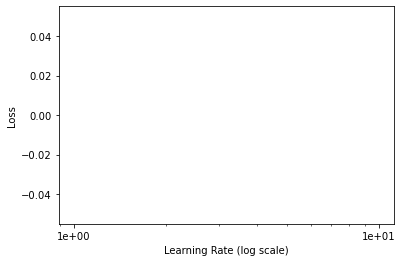

In [20]:
import matplotlib.pyplot as plt

lr.plot()

In [22]:
import pickle

pickle.dump( lr, open( "lr_finder.pkl", "wb" ) )

In [23]:
lr = pickle.load( open( "lr_finder.pkl", "rb" ) )

In [27]:
lr.lrs = [2,3]

In [28]:
lr.losses = [3,4]

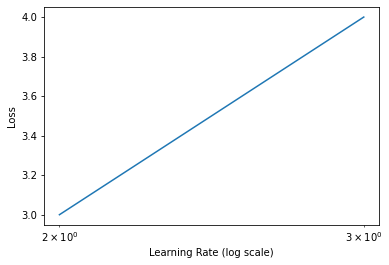

In [29]:
lr.plot()

In [30]:
lr.lrs

[2, 3]